# Bêta

Let us learn how one can compute the beta of a portfolio and its hedge with python.
Therefore, let us take a portfolio composed with only one stock (Microsoft) that we will hedge with the US equities index : S&P 500.

Microsoft : MSFT, S&P 500 : ^GSPC

A beta coefficient is a measure of the volatility, or systematic risk, of an individual stock in comparison to the unsystematic risk of the entire market. Beta is used in the capital asset pricing model (CAPM), which calculates the expected return of an asset using beta and expected market returns. 

In statistical terms, beta represents the slope of the line through a regression of data points from an individual stock's returns against those of the market.

* |beta| > 1 : the portfolio is more volatile than the market
* |beta| < 1 : the portfolio is less volatile than the market

* beta > 0 : the portfolio return tend to move in the same direction as the market
* beta < 0 : the portfolio return tend to move in the opposite direction to the market

*sources:* 
- *https://finance.yahoo.com/*
- *https://www.investopedia.com/terms/b/beta.asp*
- *https://en.wikipedia.org/wiki/Beta_(finance)*
- *https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html*
- *https://pandas.pydata.org/pandas-docs/stable/index.html*

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay
from scipy.stats import linregress

##########################
# CUSTOM DISPLAY OF FLOATS
##########################
format_float = lambda value: f'{value:.2%}' if abs(value) <= 1 else f'{value:,}'
pd.options.display.float_format = format_float

### Loading prices from csv files 

In [2]:
PRICES_FOLDER = fr"C:\Users\User\Documents\Finance\data"
RENAMING_DICT = {'Date': 'trading_date', 'Adj Close': 'adj_close'}
def compute_returns(ticker: str) -> pd.DataFrame:
    """
    Method to compute the returns of a stock from the prices file
    
    :param ticker: str
    :return: pd.DataFrame
    """
    data_file = os.path.join(PRICES_FOLDER, f'{ticker}.csv')
    df = pd.read_csv(
        filepath_or_buffer=data_file, 
        converters={'Date': pd.to_datetime}
    )
    df = df.rename(columns=RENAMING_DICT)
    df = df.set_index('trading_date')
    df['return'] = df['adj_close'].pct_change()
    returns = df[['return']].rename(columns={'return' :f'return_{ticker}'})
    return returns

In [3]:
msft_return = compute_returns(ticker='MSFT')
spy_return = compute_returns(ticker='^GSPC')
data = msft_return.merge(right=spy_return, how='inner', left_index=True, right_index=True)
data = data.dropna()

In [4]:
data.head().append(data.tail())

,return_MSFT,return_^GSPC
trading_date,,
2000-01-03,-0.16%,-0.95%
2000-01-04,-3.38%,-3.83%
2000-01-05,1.05%,0.19%
2000-01-06,-3.35%,0.10%
2000-01-07,1.31%,2.71%
2018-11-26,3.30%,1.55%
2018-11-27,0.63%,0.33%
2018-11-28,3.71%,2.30%
2018-11-29,-0.84%,-0.22%


## Computing the bêta

$r_{i}$ : return of the stock at trading date i


$h_{i}$ : return of the hedge at trading date i

$r = (r_{i})_{i \in [0, T]}$, $h = (h_{i})_{i \in [0, T]}$

First method : $\beta = \frac{cov(r, h)}{var(h)}$

Second method, by linear regression : $r = \beta * h + \alpha$

Both methods permit to compute the beta of our portfolio and our hedge.

In [5]:
stock = 'MSFT'
hedge = '^GSPC'

In [6]:
beta = data.cov()[f'return_{hedge}'][f'return_{stock}'] / data[f'return_{hedge}'].var()
slope, intercept, r_value, p_value, std_err = linregress(x=data[f'return_{hedge}'], y=data[f'return_{stock}'])

$slope = \beta$ , $intercept = alpha$

$r_{value} = corr(r, h) = \frac{cov(r, h)}{\sigma_{r} * \sigma_{h}}$

$p_{value}$ : two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic.

stderr : Standard error of the estimated gradient 

In [7]:
beta, slope

(1.0739085170087548, 1.0739085170087568)

In [8]:
print(f"THE BETA OF {stock} and {hedge} \n FROM {data.index.min().date()} TO {data.index.max().date()} \n IS {beta: 0.6}")

THE BETA OF MSFT and ^GSPC 
 FROM 2000-01-03 TO 2018-11-30 
 IS  1.07391


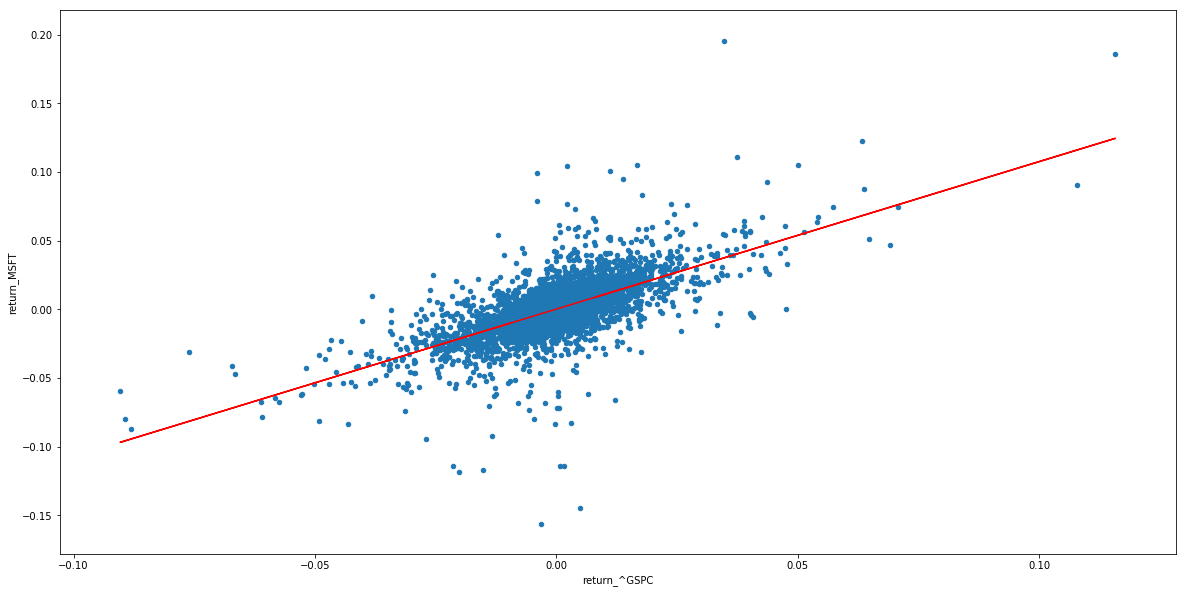

In [9]:
data.plot(x=f'return_{hedge}', y=f'return_{stock}', kind='scatter', figsize=(20, 10))
plt.plot(data[f'return_{hedge}'], intercept + slope * data[f'return_{hedge}'], 'r', label='fitted line')

## Computing the bêta for different periods 

For the precedent example, we computed the beta for the returns on the whole period 2000-01-03 TO 2018-11-30.

Let us see how one can compute it for different periods, with rolling functions.

In [10]:
beta_10d = (
    data.rolling(window=10).cov()[f'return_{hedge}'].xs(f"return_{stock}", level=1) / 
    data.rolling(window=10).var()[f'return_{hedge}']
).dropna().to_frame().rename(columns={f'return_{hedge}': 'beta_10d'})

beta_3m = (
    data.rolling(window=60).cov()[f'return_{hedge}'].xs(f"return_{stock}", level=1) / 
    data.rolling(window=60).var()[f'return_{hedge}']
).dropna().to_frame().rename(columns={f'return_{hedge}': 'beta_3m'})
beta_6m = (
    data.rolling(window=120).cov()[f'return_{hedge}'].xs(f"return_{stock}", level=1) / 
    data.rolling(window=120).var()[f'return_{hedge}']
).dropna().to_frame().rename(columns={f'return_{hedge}': 'beta_6m'})
beta_1y = (
    data.rolling(window=250).cov()[f'return_{hedge}'].xs(f"return_{stock}", level=1) / 
    data.rolling(window=250).var()[f'return_{hedge}']
).dropna().to_frame().rename(columns={f'return_{hedge}': 'beta_1y'})

beta = beta_1y.merge(beta_6m, how='left', left_index=True, right_index=True)
beta = beta.merge(beta_3m, how='left', left_index=True, right_index=True)
beta = beta.merge(beta_10d, how='left', left_index=True, right_index=True)

In [11]:
beta.head().append(beta.tail())

,beta_1y,beta_6m,beta_3m,beta_10d
trading_date,,,,
2000-12-27,1.3641401308864172,1.668340449513831,1.8999659887600424,2.747072414694144
2000-12-28,1.3630734785291234,1.6546572156486168,1.8706646080493017,2.7030144693141693
2000-12-29,1.3822574420982505,1.6597658364395254,1.888802669725221,2.758441448642907
2001-01-02,1.3578295258143076,1.5867310932005587,1.7934472737245626,1.657958704390604
2001-01-03,1.3978796273145466,1.6549037407208664,1.8792443117849629,1.9667488244952722
2018-11-26,1.4779757700949072,1.5641169048217585,1.5887622552438367,1.8146712549936186
2018-11-27,1.4776282702821237,1.5633526370261397,1.5881711605535505,1.901854358372519
2018-11-28,1.481004282923414,1.5632564469871122,1.5851329409770925,1.7577241245206765
2018-11-29,1.4819640610860205,1.5657127386439817,1.5794982789724017,1.7526727909925555
